In [2]:
import pandas as pd

In [6]:
# Load each sheet into a DataFrame to inspect the data
customers = pd.read_excel('/content/E-commerce_data.xlsx', sheet_name='customers')
genders = pd.read_excel('/content/E-commerce_data.xlsx', sheet_name='genders')
cities = pd.read_excel('/content/E-commerce_data.xlsx', sheet_name='cities')
transactions = pd.read_excel('/content/E-commerce_data.xlsx', sheet_name='transactions')
branches = pd.read_excel('/content/E-commerce_data.xlsx', sheet_name='branches')
merchants = pd.read_excel('/content/E-commerce_data.xlsx', sheet_name='merchants')

# Preview the first few rows of each sheet
(customers.head(), genders.head(), cities.head(), transactions.head(), branches.head(), merchants.head())

(   customer_id  join_date  city_id  gender_id
 0            1 2022-01-08        7          1
 1            2 2023-05-02       20          2
 2            3 2023-05-14       15          1
 3            4 2022-11-25       11          2
 4            5 2023-04-26        8          1,
    gender_id gender_name
 0          1        Male
 1          2      Female,
    city_id         city_name
 0        1             Cairo
 1        2        Alexandria
 2        3              Giza
 3        4  Shubra El-Kheima
 4        5         Port Said,
    transaction_id  customer_id transaction_date transaction_status  \
 0               1          733       2024-05-11         subscribed   
 1               2          631       2023-05-15             burned   
 2               3          309       2022-11-13         subscribed   
 3               4          695       2024-01-26         subscribed   
 4               5          288       2022-10-12             burned   
 
   coupon_name  burn_date  br

In [8]:
# Merging the tables to create a comprehensive dataset for analysis

# First, merge the customers table with the genders and cities tables to get complete customer demographic info
customers_full = pd.merge(customers, genders, on='gender_id', how='left')
customers_full = pd.merge(customers_full, cities, on='city_id', how='left')

# Now, merge the transactions with branches and merchants to get full transactional data
transactions_full = pd.merge(transactions, branches, on='branch_id', how='left')
transactions_full = pd.merge(transactions_full, merchants, on='merchant_id', how='left')

# Finally, merge the complete customers and transactions tables on customer_id
ecommerce_full = pd.merge(transactions_full, customers_full, on='customer_id', how='left')

# Check for any missing values in the combined dataset
missing_values = ecommerce_full.isnull().sum()

# Preview the combined dataset and missing values
ecommerce_full_preview = ecommerce_full.head()
ecommerce_full_preview, missing_values


(   transaction_id  customer_id transaction_date transaction_status  \
 0               1          733       2024-05-11         subscribed   
 1               2          631       2023-05-15             burned   
 2               3          309       2022-11-13         subscribed   
 3               4          695       2024-01-26         subscribed   
 4               5          288       2022-10-12             burned   
 
   coupon_name  burn_date  branch_id  merchant_id  \
 0     uNY-568        NaT          7            7   
 1     kBx-219 2023-06-04          5            9   
 2     PLG-122        NaT          7            7   
 3     Wzf-897        NaT          2           18   
 4     qGb-428 2022-11-20          6           15   
 
                     merchant_name  join_date  city_id  gender_id gender_name  \
 0                  Berry-Anderson 2023-05-16       15          2      Female   
 1  Campbell, Shaffer and Martinez 2022-10-10       14          2      Female   
 2       

In [9]:
# Handling missing values in the `burn_date` column
# We will assume that missing `burn_date` values mean the coupon was not burnt.

# Create a new column 'is_burnt' to indicate if the coupon was burnt
ecommerce_full['is_burnt'] = ecommerce_full['burn_date'].notna().astype(int)

# Drop the 'burn_date' column as it's no longer needed
ecommerce_full_clean = ecommerce_full.drop(columns=['burn_date'])

# Now we will proceed with feature selection for customer segmentation
# We will use the following columns for segmentation:
# - 'customer_id', 'gender_name', 'city_name', 'transaction_status', 'is_burnt'

# Select relevant columns for clustering
segmentation = ecommerce_full_clean[['customer_id', 'gender_name', 'city_name', 'transaction_status', 'is_burnt']]

# Let's encode categorical columns like gender_name, city_name, and transaction_status for clustering
segmentation_encoded = pd.get_dummies(segmentation, columns=['gender_name', 'city_name', 'transaction_status'], drop_first=True)

# Preview the encoded dataset
segmentation_encoded.head()


,customer_id,is_burnt,gender_name_Male,city_name_Aswan,city_name_Asyut,city_name_Beni Suef,city_name_Cairo,city_name_Damanhur,city_name_Damietta,city_name_El-Mahalla El-Kubra,...,city_name_Mansoura,city_name_Minya,city_name_Port Said,city_name_Qena,city_name_Shubra El-Kheima,city_name_Sohag,city_name_Suez,city_name_Tanta,city_name_Zagazig,transaction_status_subscribed
0,733,0,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,631,1,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
2,309,0,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,695,0,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,288,1,True,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False


In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
segmentation_scaled = scaler.fit_transform(segmentation_encoded)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

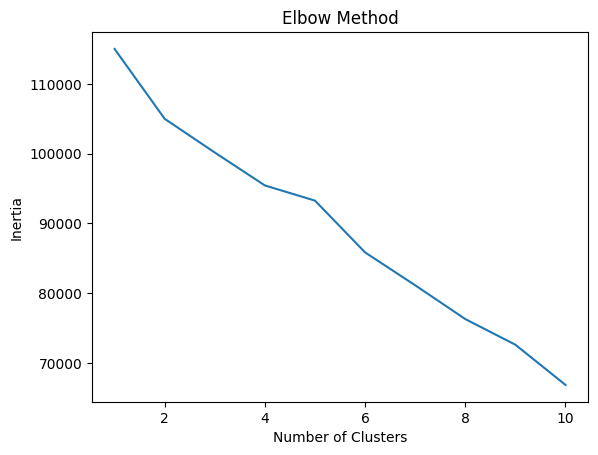

In [12]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Elbow method to determine the optimal number of clusters
inertia = []
for n in range(1, 11):
    kmeans = KMeans(n_clusters=n, random_state=42)
    kmeans.fit(segmentation_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, 11), inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

In [14]:
from sklearn.metrics import silhouette_score

# Assuming you identified the optimal number of clusters as 4 from the elbow method
optimal_clusters = 4  # Assign the value you determined from the elbow method

kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(segmentation_scaled)
silhouette_avg = silhouette_score(segmentation_scaled, cluster_labels)
print(f'Silhouette Score: {silhouette_avg}')

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score: 0.1369122884448828
